In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [4]:
df = pd.read_excel('Online_Retail.xlsx')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [5]:
print(df.groupby('CustomerID')['InvoiceNo'].count())
print(df.groupby('CustomerID')['Quantity'].sum())

CustomerID
12346.0      2
12347.0    182
12348.0     31
12349.0     73
12350.0     17
          ... 
18280.0     10
18281.0      7
18282.0     13
18283.0    756
18287.0     70
Name: InvoiceNo, Length: 4372, dtype: int64
CustomerID
12346.0       0
12347.0    2458
12348.0    2341
12349.0     631
12350.0     197
           ... 
18280.0      45
18281.0      54
18282.0      98
18283.0    1397
18287.0    1586
Name: Quantity, Length: 4372, dtype: int64


In [7]:
df.describe()

,Quantity,InvoiceDate,UnitPrice,CustomerID
count,541909.000000,541909,541909.000000,406829.000000
mean,9.552250,2011-07-04 13:34:57.156386048,4.611114,15287.690570
min,-80995.000000,2010-12-01 08:26:00,-11062.060000,12346.000000
25%,1.000000,2011-03-28 11:34:00,1.250000,13953.000000
50%,3.000000,2011-07-19 17:17:00,2.080000,15152.000000
75%,10.000000,2011-10-19 11:27:00,4.130000,16791.000000
max,80995.000000,2011-12-09 12:50:00,38970.000000,18287.000000
std,218.081158,NaN,96.759853,1713.600303


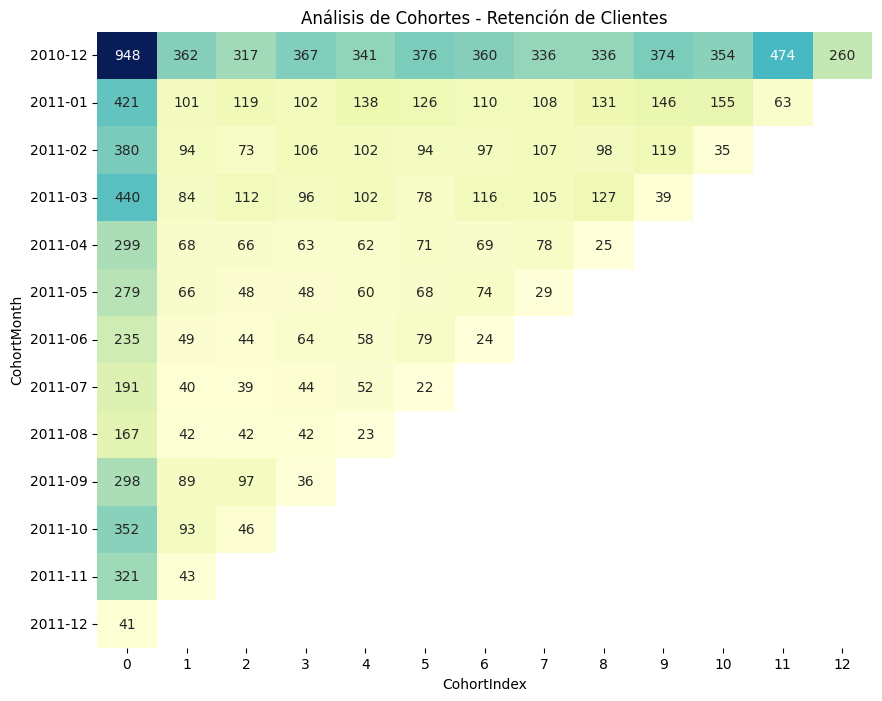

In [11]:
# Convertir la columna 'InvoiceDate' a formato de fecha
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Extraer el mes de la columna 'InvoiceDate' como una nueva columna 'InvoiceMonth'
df['InvoiceMonth'] = df['InvoiceDate'].dt.to_period('M')

# Crear una columna 'CohortMonth' para representar el primer mes en el que cada cliente realizó una compra
df['CohortMonth'] = df.groupby('CustomerID')['InvoiceDate'].transform('min').dt.to_period('M')

# Calcular la diferencia en meses entre 'InvoiceMonth' y 'CohortMonth'
df['CohortIndex'] = df['InvoiceMonth'].astype('int64') - df['CohortMonth'].astype('int64')

# Calcular métricas relevantes por cohortes
cohort_data = df.groupby(['CohortMonth', 'CohortIndex'])['CustomerID'].nunique().reset_index()

# Crear una tabla pivot para visualizar los resultados
cohort_counts = cohort_data.pivot_table(index='CohortMonth', columns='CohortIndex', values='CustomerID')

# Crear un heatmap para visualizar el análisis de cohortes
#Las filas representas los meses en los que los clientes realizaron su primera compra
#Las columnas representas los diferente periodos de tiempo o semanas posteriores a la primera compra
#Asi se indica cuandots clientes siguen comprando en el tiempo
plt.figure(figsize=(10, 8))
plt.title('Análisis de Cohortes - Retención de Clientes')
sns.heatmap(data=cohort_counts, annot=True, cmap='YlGnBu', fmt='g', cbar=False)
plt.show()

In [14]:
# Calcular el comportamiento de compra repetida por cohortes
repeat_purchase_data = df.groupby(['CohortMonth', 'CustomerID'])['InvoiceNo'].nunique()
average_repeat_purchase = repeat_purchase_data.groupby('CohortMonth').mean()

# Identificar patrones de compra repetida

# Calcular métricas de compra repetida
repurchase_rate = repeat_purchase_data[repeat_purchase_data > 1].groupby('CohortMonth').count() / df.groupby('CohortMonth')['CustomerID'].nunique()
average_purchase_value = df.groupby(['CohortMonth', 'CustomerID'])['UnitPrice'].sum().groupby('CohortMonth').mean()

# Convertir los períodos a cadenas para su uso en la visualización
cohort_labels = repurchase_rate.index.astype(str)


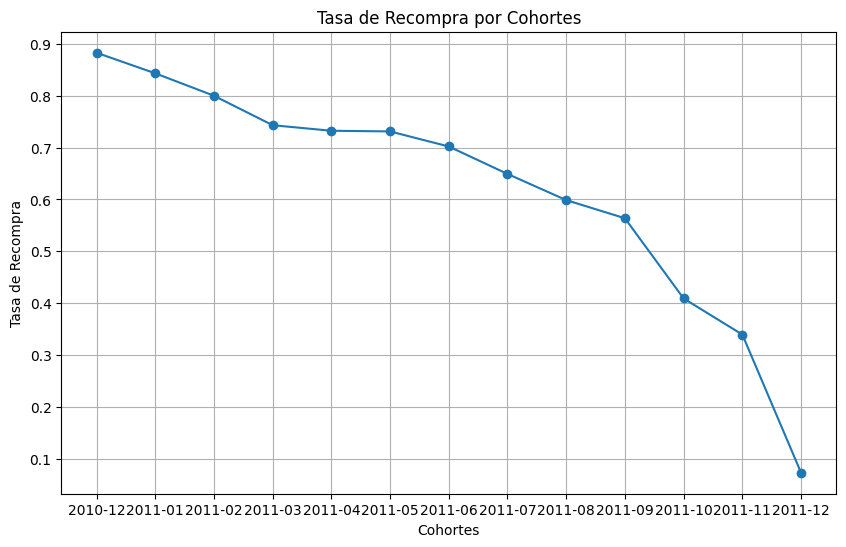

In [15]:
# Gráfico de líneas para la tasa de recompra
plt.figure(figsize=(10, 6))
plt.plot(cohort_labels, repurchase_rate.values, marker='o', linestyle='-')
plt.title('Tasa de Recompra por Cohortes')
plt.xlabel('Cohortes')
plt.ylabel('Tasa de Recompra')
plt.grid(True)
plt.show()

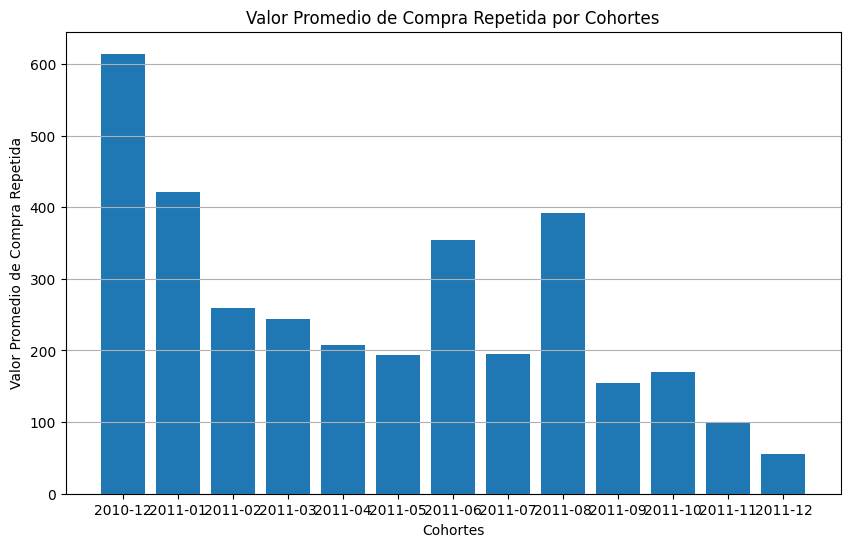

In [16]:
# Gráfico de barras para el valor promedio de compra repetida
plt.figure(figsize=(10, 6))
plt.bar(cohort_labels, average_purchase_value.values)
plt.title('Valor Promedio de Compra Repetida por Cohortes')
plt.xlabel('Cohortes')
plt.ylabel('Valor Promedio de Compra Repetida')
plt.grid(axis='y')
plt.show()

In [19]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Preprocesamiento de datos
X = df[['Quantity', 'UnitPrice']]  # Selecciona las columnas relevantes para el clustering
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [20]:
# Entrenar el modelo de K-means
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(X_scaled)
df['Cluster'] = kmeans.labels_

c:\Users\aleja\OneDrive\Escritorio\Dev-DS\env\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


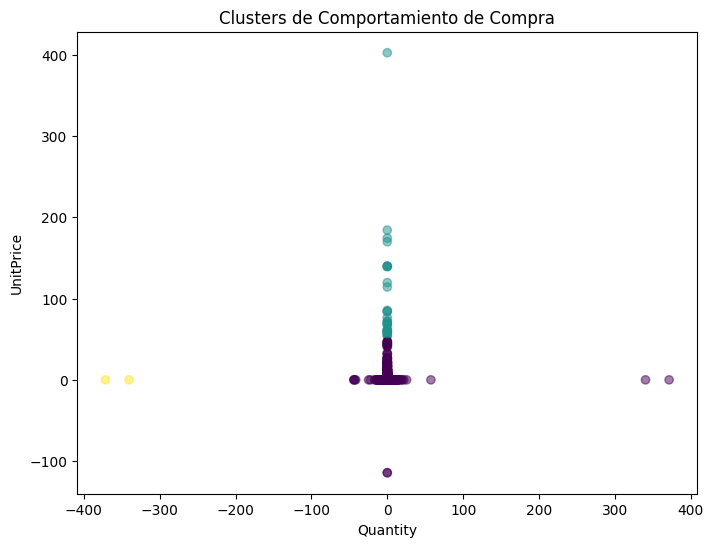

In [21]:
# Visualizar los clusters
plt.figure(figsize=(8, 6))
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=kmeans.labels_, cmap='viridis', alpha=0.5)
plt.xlabel('Quantity')
plt.ylabel('UnitPrice')
plt.title('Clusters de Comportamiento de Compra')
plt.show()

In [23]:
# Analizar los perfiles de cada cluster
cluster_profiles = df.groupby('Cluster').agg({'Quantity': 'mean', 'UnitPrice': 'mean'})
print(cluster_profiles)

             Quantity    UnitPrice
Cluster                           
0            9.839308     4.054723
1           -0.806452  9730.436452
2       -77605.000000     1.560000
